In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# 세로 이미지에 좌우 여백을 추가 (세로 사이즈로 통일)
def add_padding_left_right(img:np.ndarray, color) -> np.ndarray:
    padding = (img.shape[0] - img.shape[1]) // 2
    img = cv2.copyMakeBorder(img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return img

# 이미지 회전
# bg_color -> 회전하고 남은 여백을 채울 색깔
def rotate_img(img:np.ndarray, degree, bg_color) -> np.ndarray:
    h, w = img.shape[:2]
    cy, cx = (h // 2), (w // 2)
    M = cv2.getRotationMatrix2D((cx, cy), degree, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderValue=bg_color)
    return img

(224, 224, 3)


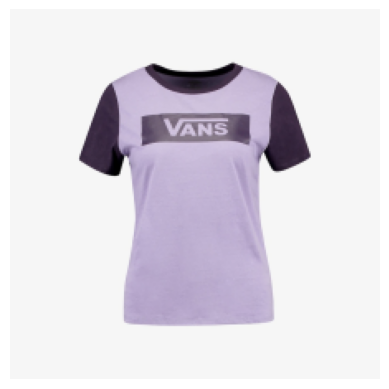

In [5]:
# 데이터 미리보기 

img = cv2.imread('./dataset/00055_00.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = add_padding_left_right(img, color=(246, 246, 246))
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
img = rotate_img(img, 0, bg_color=(246, 246, 246))

print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()




In [6]:
img

array([[[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]],

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]],

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]],

       ...,

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]],

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]],

       [[246, 246, 246],
        [246, 246, 246],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [246, 246, 246]]

In [7]:
image_files = np.array([os.path.join('./dataset', file) for file in os.listdir('./dataset')])
mask = np.random.choice(len(image_files), int(len(image_files) * 0.2), replace=False)



train_data = [] # (label, img)
test_data = []

for i in range(len(image_files)):
    img = cv2.imread(image_files[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = add_padding_left_right(img, color=(246, 246, 246))
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    degrees = np.random.choice(range(360), 5, replace=False)
    for degree in degrees:
        rotated_img = rotate_img(img, degree, bg_color=(246, 246, 246))
        rotated_img = rotated_img.transpose((2, 0, 1)) #(H, W, CH) -> (CH, H, W)
        if i in mask:
            test_data.append((rotated_img, degree))
        else:
            train_data.append((rotated_img, degree))

print(len(train_data), len(test_data))

8130 2030


<Axes: ylabel='Count'>

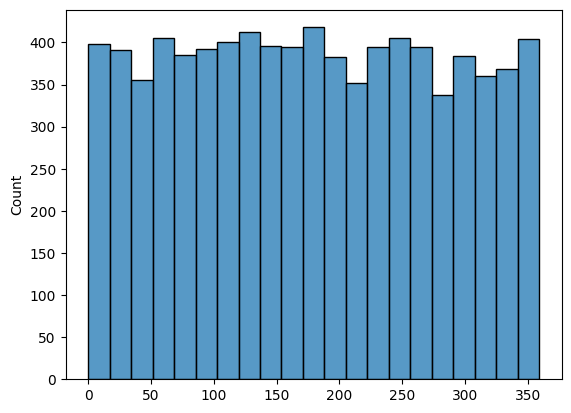

In [8]:
sns.histplot([x[1] for x in train_data])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_list) -> None:
        super().__init__()
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # 정규화, 
        sample = torch.tensor(self.data[index][0]).float()
        label = torch.tensor(self.data[index][1]).float()
        return sample, label



train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
for data in train_loader:
    x, y = data
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])


In [12]:
data[0].shape

torch.Size([32, 3, 256, 256])

TypeError: Invalid shape (3, 256, 256) for image data

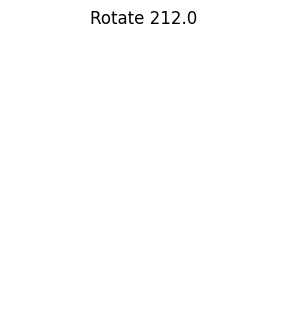

In [13]:
data = next(iter(test_loader))

fig = plt.figure(figsize=(16, 16))
colums = 4
rows = 4
for i in range(1, colums * rows + 1):
    img = test_dataset[i][0].int() # 28x28 이미지
    fig.add_subplot(rows, colums, i)
    plt.title(f'Rotate {test_dataset[i][1]}')
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [ ]:
class ClothAngleCorrection(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 3x128x128 -> 32x128x128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128 -> 32x64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32x64x64 -> 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64 -> 64x32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64x32x32 -> 128x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32 -> 128x16x16
        )

        self.fc = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    
    def forward(self, x:torch.Tensor):
        x = self.layer(x)
        x = x.view(-1, 128*16*16)
        x = self.fc(x)
        return x
        

In [14]:
from torchvision.models import resnet50
# model = ClothAngleCorrection()
# model.to(device)

model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)

criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
model



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\reclos/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:27<00:00, 3.72MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# 모델 학습

num_epochs = 10
count = 0

train_loss = []
test_loss = []



for epoch in range(num_epochs):
    epoch_train_loss = []
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        epoch_train_loss.append(loss.data.cpu())


    train_loss.append(np.mean(epoch_train_loss))

    epoch_test_loss = []
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        x_test = x_test

        with torch.no_grad():
            outputs = model(x_test)
            loss = criterion(outputs, y_test)
            
            epoch_test_loss.append(loss.data.cpu())
    
    test_loss.append(np.mean(epoch_test_loss))
    
    torch.save(model.state_dict(), os.path.join('./models', '{0:0=2d}.pth'.format(epoch)))
        
    
    print(f'Epoch: {epoch}, Train_MAE:{np.mean(epoch_train_loss)}, Test_MAE:{np.mean(epoch_test_loss)}')
            
    
    

Epoch: 0, Train_MSE:93.15325927734375, Test_MSE:91.87818908691406
Epoch: 1, Train_MSE:90.3990249633789, Test_MSE:91.5365982055664
Epoch: 2, Train_MSE:90.46370697021484, Test_MSE:91.64443969726562
Epoch: 3, Train_MSE:90.76764678955078, Test_MSE:91.78817749023438
Epoch: 4, Train_MSE:90.13699340820312, Test_MSE:91.63723754882812
Epoch: 5, Train_MSE:90.23961639404297, Test_MSE:92.09178924560547
Epoch: 6, Train_MSE:90.55168151855469, Test_MSE:91.59538269042969
Epoch: 7, Train_MSE:90.19635009765625, Test_MSE:92.03511047363281
Epoch: 8, Train_MSE:90.22914123535156, Test_MSE:91.87843322753906
Epoch: 9, Train_MSE:90.24808502197266, Test_MSE:91.44972229003906


([93.15326,
  90.399025,
  90.46371,
  90.76765,
  90.13699,
  90.23962,
  90.55168,
  90.19635,
  90.22914,
  90.248085],
 [91.87819,
  91.5366,
  91.64444,
  91.78818,
  91.63724,
  92.09179,
  91.59538,
  92.03511,
  91.87843,
  91.44972])